## Setup, Loading Data and CDFs

In [3]:
DATA_NAME = 'approx1e5-pastis-fourier-gray' # size-name-transform-channel

In [4]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/fourier/approx1e5/gray'

In [5]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [6]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
else:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 31800,
 3: 22260,
 4: 44520,
 5: 41340,
 6: 50880,
 7: 54060,
 8: 66780,
 9: 63600,
 10: 85860,
 11: 104940,
 12: 111300,
 13: 136740,
 14: 162180,
 15: 187620,
 16: 203520,
 17: 257580,
 18: 289380,
 19: 337080,
 20: 381600,
 21: 470640,
 22: 540600,
 23: 610560,
 24: 712320,
 25: 855420,
 26: 973080,
 27: 1154340,
 28: 1316520,
 29: 1376940,
 30: 960360,
 31: 674160,
 32: 419760}

In [7]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:818: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:45<00:00, 2218.45it/s]


Band 5


100%|██████████| 100000/100000 [00:50<00:00, 1966.36it/s]


Band 8


100%|██████████| 100000/100000 [00:57<00:00, 1732.87it/s]


Band 11


100%|██████████| 100000/100000 [00:46<00:00, 2162.26it/s]


Band 14


100%|██████████| 100000/100000 [00:49<00:00, 2040.18it/s]


Band 17


100%|██████████| 100000/100000 [00:47<00:00, 2101.75it/s]


Band 20


100%|██████████| 100000/100000 [00:46<00:00, 2172.61it/s]


Band 23


100%|██████████| 100000/100000 [00:46<00:00, 2162.83it/s]


Band 26


100%|██████████| 100000/100000 [00:49<00:00, 2024.65it/s]


Band 29


100%|██████████| 100000/100000 [00:46<00:00, 2162.15it/s]


Band 32


100%|██████████| 100000/100000 [00:45<00:00, 2193.38it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,166042.38000,157998.030469,174433.438828,1.621352,1.183683,2.159778,31800.0
5,88873.20000,84620.583672,93301.832852,1.556882,1.034867,2.247036,41340.0
8,48739.90600,46426.743379,51128.367246,1.541574,1.065818,2.175572,66780.0
11,27771.78000,26384.786582,29233.971729,1.922300,1.152667,3.322006,104940.0
14,15175.32700,14446.182202,15943.683618,1.705795,1.083742,3.005844,162180.0
17,8489.96700,8074.939258,8925.657485,1.771589,1.108579,3.490514,257580.0
20,4270.11670,4059.782000,4497.974688,1.956200,1.143715,5.900501,381600.0
23,2001.44800,1901.448419,2108.500648,2.041856,1.252694,3.881747,610560.0
26,805.73254,756.140120,869.276880,5.035483,1.824683,19.982925,973080.0


## Initial Grid Search and Hypothesis Test Plots

####
Band  2


100%|██████████| 55966/55966 [01:10<00:00, 795.99it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 31800, Without approximation : 31800.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


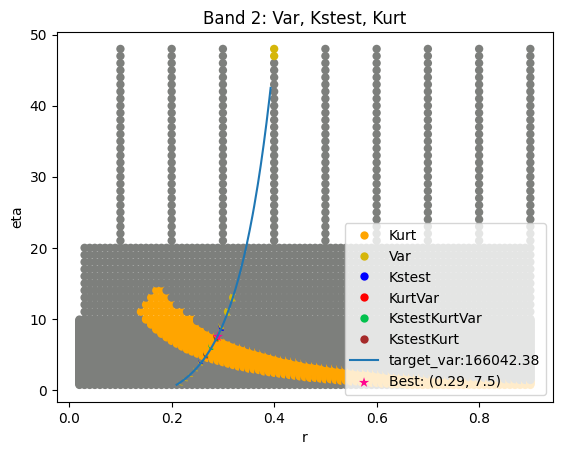

####
Band  5


100%|██████████| 55966/55966 [01:22<00:00, 679.49it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 41340, Without approximation : 41340.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


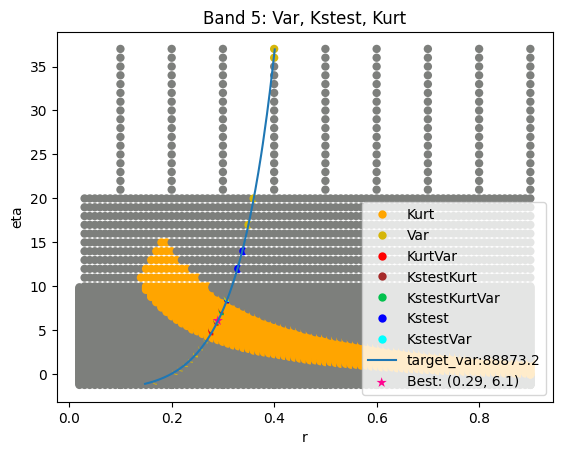

####
Band  8


100%|██████████| 55966/55966 [02:12<00:00, 422.39it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 66780, Without approximation : 66780.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


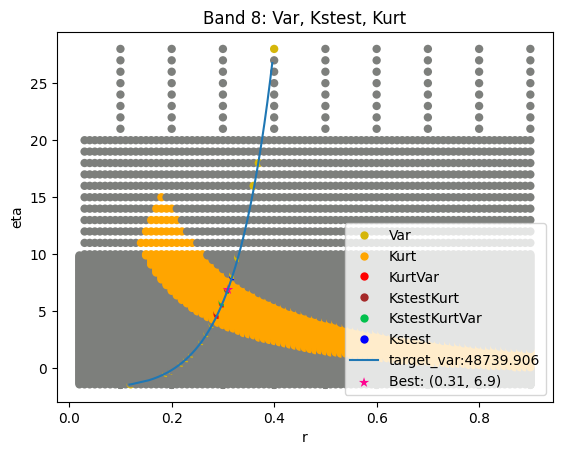

####
Band  11


100%|██████████| 55966/55966 [03:25<00:00, 271.89it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 104940.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


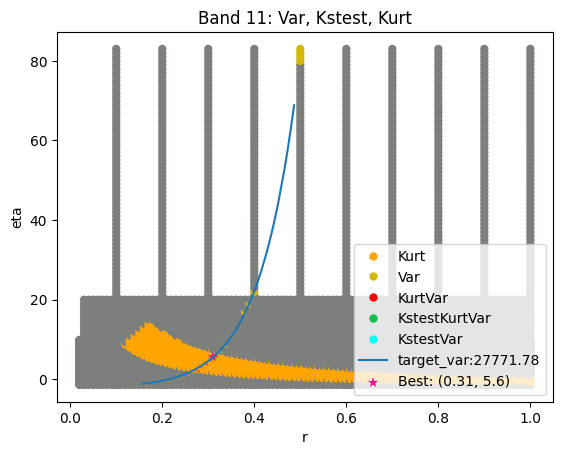

####
Band  14


100%|██████████| 55966/55966 [03:16<00:00, 284.83it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 162180.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


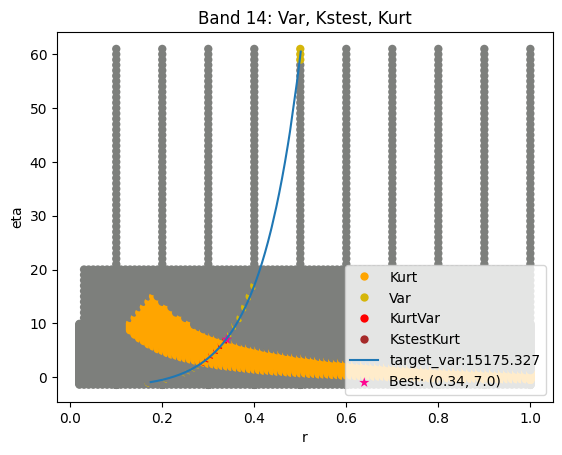

####
Band  17


100%|██████████| 55966/55966 [03:21<00:00, 278.16it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 257580.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


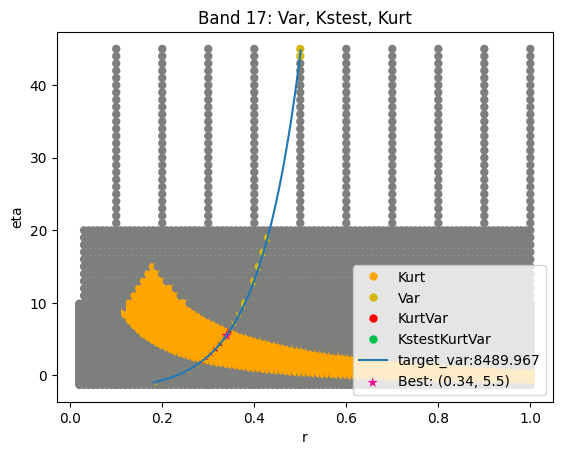

####
Band  20


100%|██████████| 55966/55966 [03:10<00:00, 293.80it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 381600.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


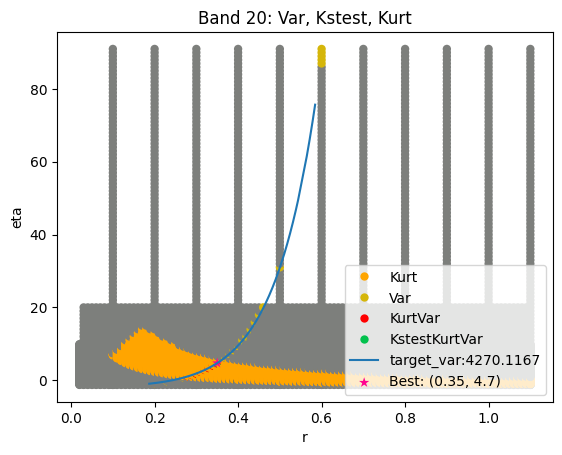

####
Band  23


100%|██████████| 55966/55966 [03:13<00:00, 288.99it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 610560.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


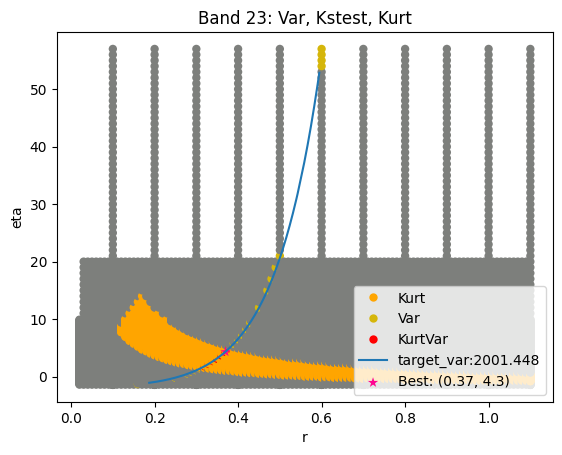

####
Band  26


100%|██████████| 55966/55966 [03:26<00:00, 270.41it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 973080.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


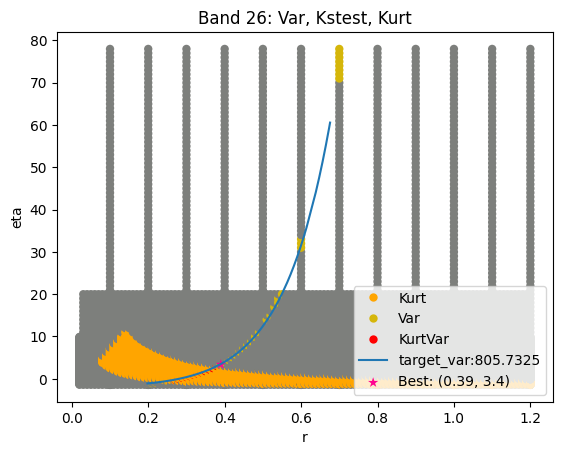

####
Band  29


100%|██████████| 55966/55966 [03:15<00:00, 286.54it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 1376940.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


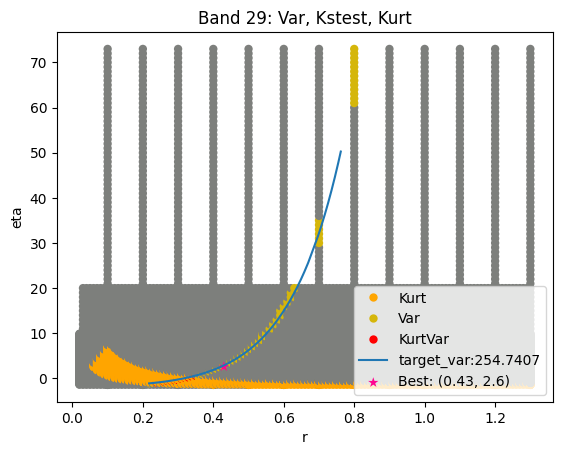

####
Band  32


100%|██████████| 55966/55966 [03:18<00:00, 281.50it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 419760.0


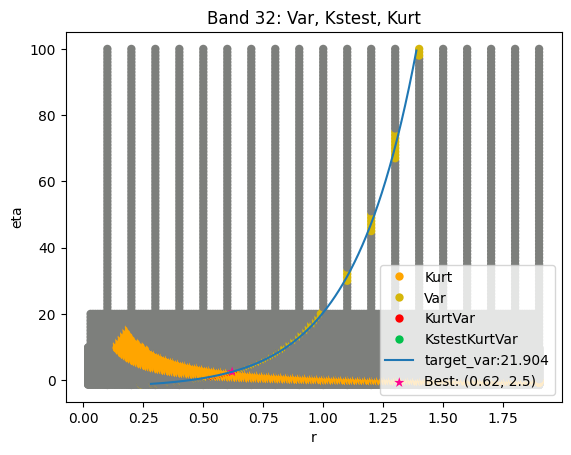

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05
band,,,,,,,,,,,
2,166042.38000,157998.030469,174433.438828,1.621352,1.183683,2.159778,31800.0,0.29,7.5,0.004660,0.007611
5,88873.20000,84620.583672,93301.832852,1.556882,1.034867,2.247036,41340.0,0.29,6.1,0.003241,0.006675
8,48739.90600,46426.743379,51128.367246,1.541574,1.065818,2.175572,66780.0,0.31,6.9,0.003290,0.005253
11,27771.78000,26384.786582,29233.971729,1.922300,1.152667,3.322006,104940.0,0.31,5.6,0.003337,0.004191
14,15175.32700,14446.182202,15943.683618,1.705795,1.083742,3.005844,162180.0,0.34,7.0,0.002828,0.003371
17,8489.96700,8074.939258,8925.657485,1.771589,1.108579,3.490514,257580.0,0.34,5.5,0.001488,0.002675
20,4270.11670,4059.782000,4497.974688,1.956200,1.143715,5.900501,381600.0,0.35,4.7,0.000914,0.002198
23,2001.44800,1901.448419,2108.500648,2.041856,1.252694,3.881747,610560.0,0.37,4.3,0.002168,0.001738
26,805.73254,756.140120,869.276880,5.035483,1.824683,19.982925,973080.0,0.39,3.4,0.001724,0.001377


In [10]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = master_df.loc[group, 'obs_var'],
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

        # Optional: Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [11]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
            best_params_eta0.append(best_param_eta0[0])
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            best_params_eta0.append(master_df.loc[group, 'initial_r'])
    master_df['best_r_eta0'] = best_params_eta0
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 777.78it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 629.67it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 423.49it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 300.78it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 302.43it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 283.28it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 270.47it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 303.57it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 304.69it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 283.30it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 301.93it/s]


Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
band,,,,,,,,,,,,,
2,166042.38000,157998.030469,174433.438828,1.621352,1.183683,2.159778,31800.0,0.29,7.5,0.004660,0.007611,0.052448,0.18
5,88873.20000,84620.583672,93301.832852,1.556882,1.034867,2.247036,41340.0,0.29,6.1,0.003241,0.006675,0.068900,0.18
8,48739.90600,46426.743379,51128.367246,1.541574,1.065818,2.175572,66780.0,0.31,6.9,0.003290,0.005253,0.048838,0.19
11,27771.78000,26384.786582,29233.971729,1.922300,1.152667,3.322006,104940.0,0.31,5.6,0.003337,0.004191,0.048296,0.20
14,15175.32700,14446.182202,15943.683618,1.705795,1.083742,3.005844,162180.0,0.34,7.0,0.002828,0.003371,0.055859,0.21
17,8489.96700,8074.939258,8925.657485,1.771589,1.108579,3.490514,257580.0,0.34,5.5,0.001488,0.002675,0.055111,0.22
20,4270.11670,4059.782000,4497.974688,1.956200,1.143715,5.900501,381600.0,0.35,4.7,0.000914,0.002198,0.045778,0.23
23,2001.44800,1901.448419,2108.500648,2.041856,1.252694,3.881747,610560.0,0.37,4.3,0.002168,0.001738,0.038232,0.24
26,805.73254,756.140120,869.276880,5.035483,1.824683,19.982925,973080.0,0.39,3.4,0.001724,0.001377,0.038327,0.26


## Optimization

In [12]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

Band 2
(0.282, 7.49), 50 of 420
(0.284, 7.59), 100 of 420
(0.287, 7.49), 150 of 420
(0.289, 7.59), 200 of 420
(0.292, 7.49), 250 of 420
(0.294, 7.59), 300 of 420
(0.297, 7.49), 350 of 420


## Comparing Empirical and Computed CDF/PDF

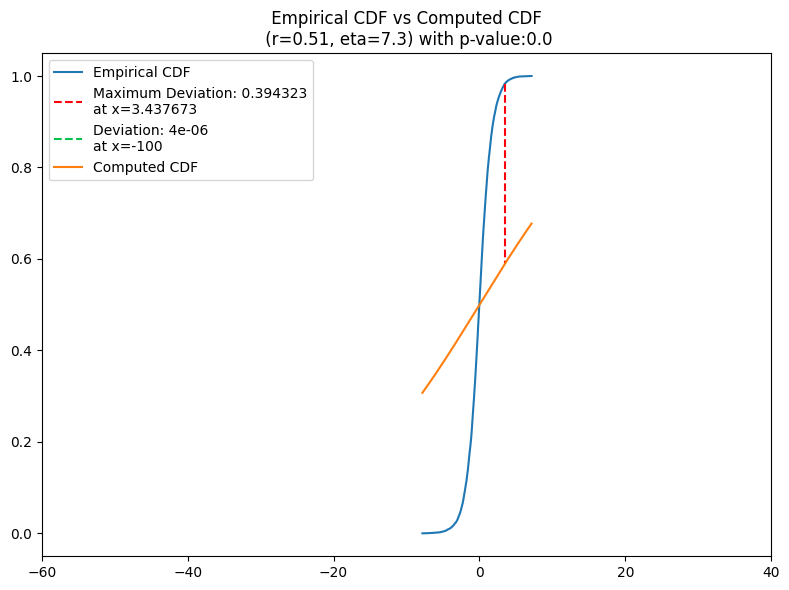

In [ ]:
# Example Cell
group = 2
visualize_cdf(sample = group_data_map[group], 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

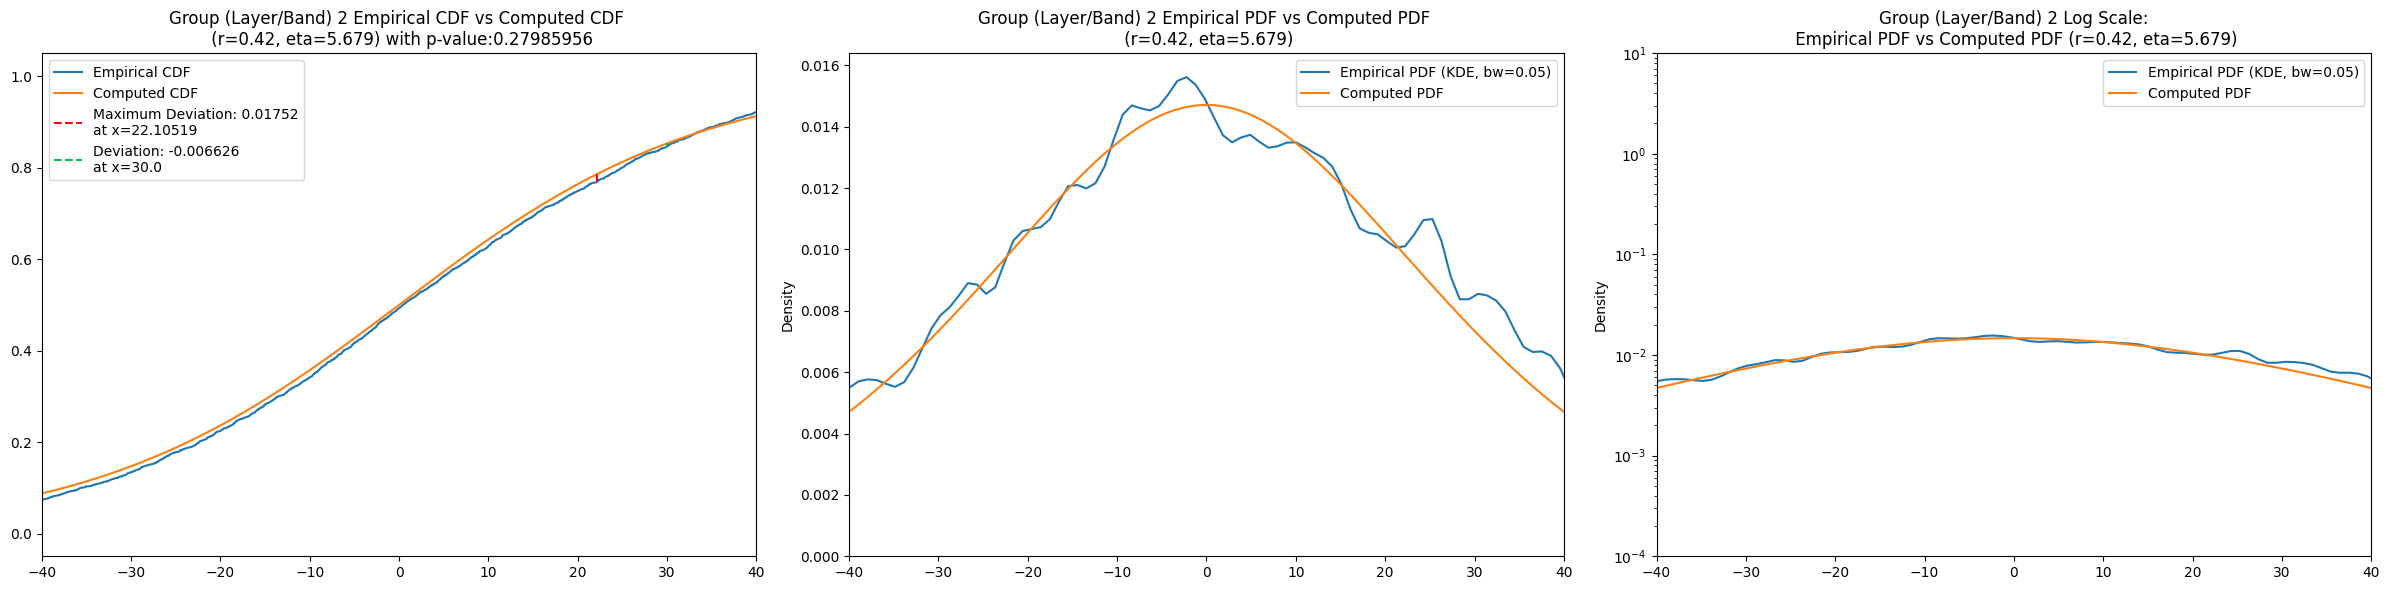

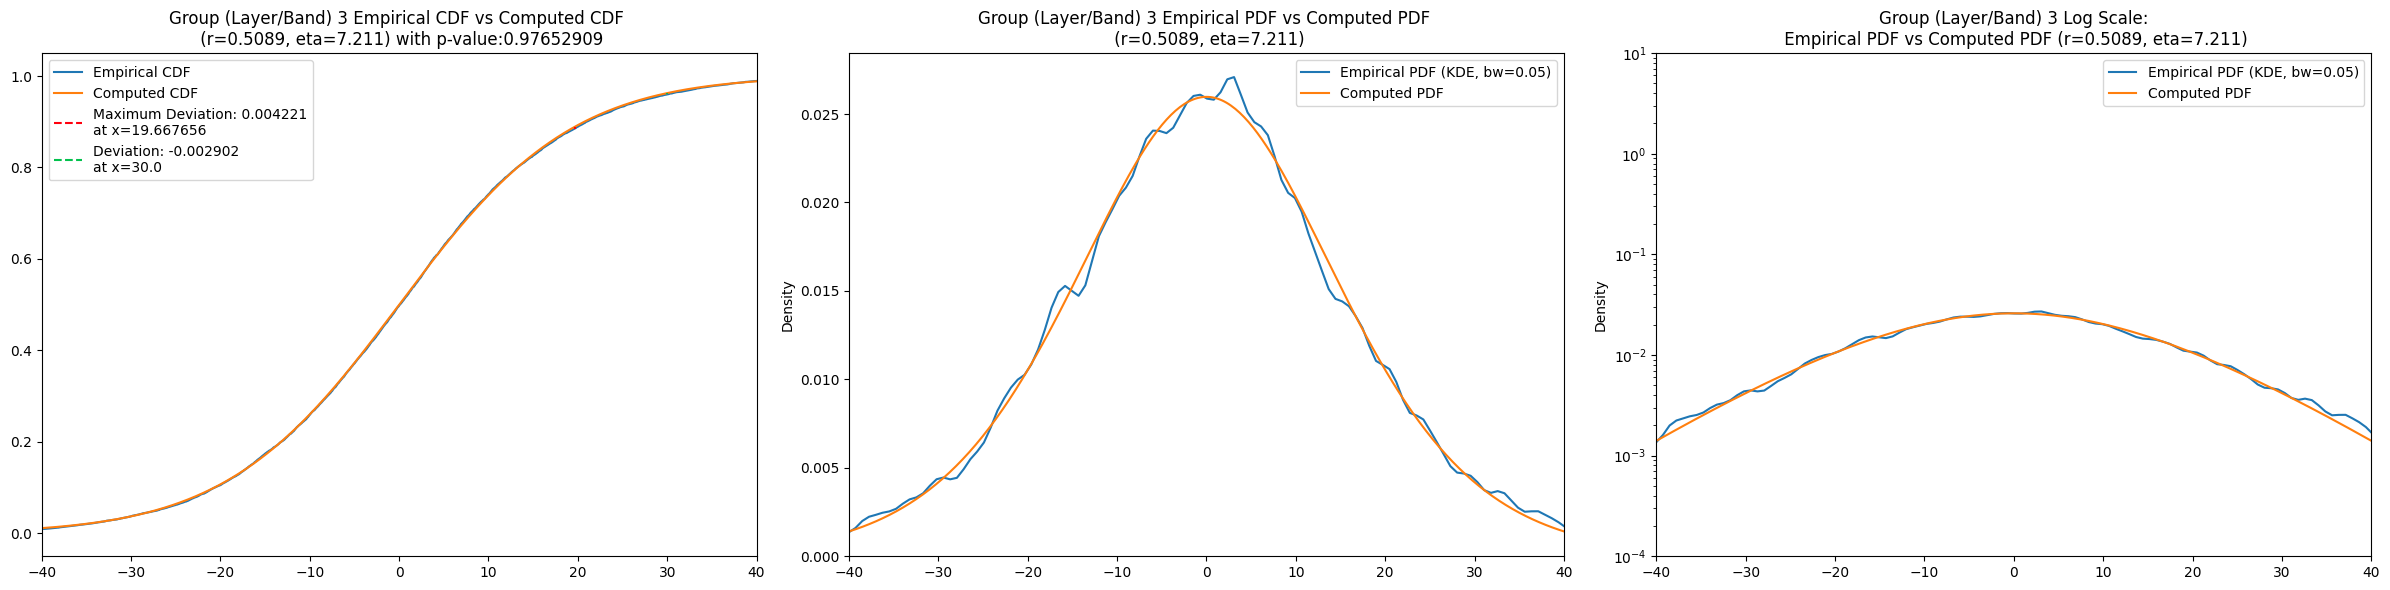

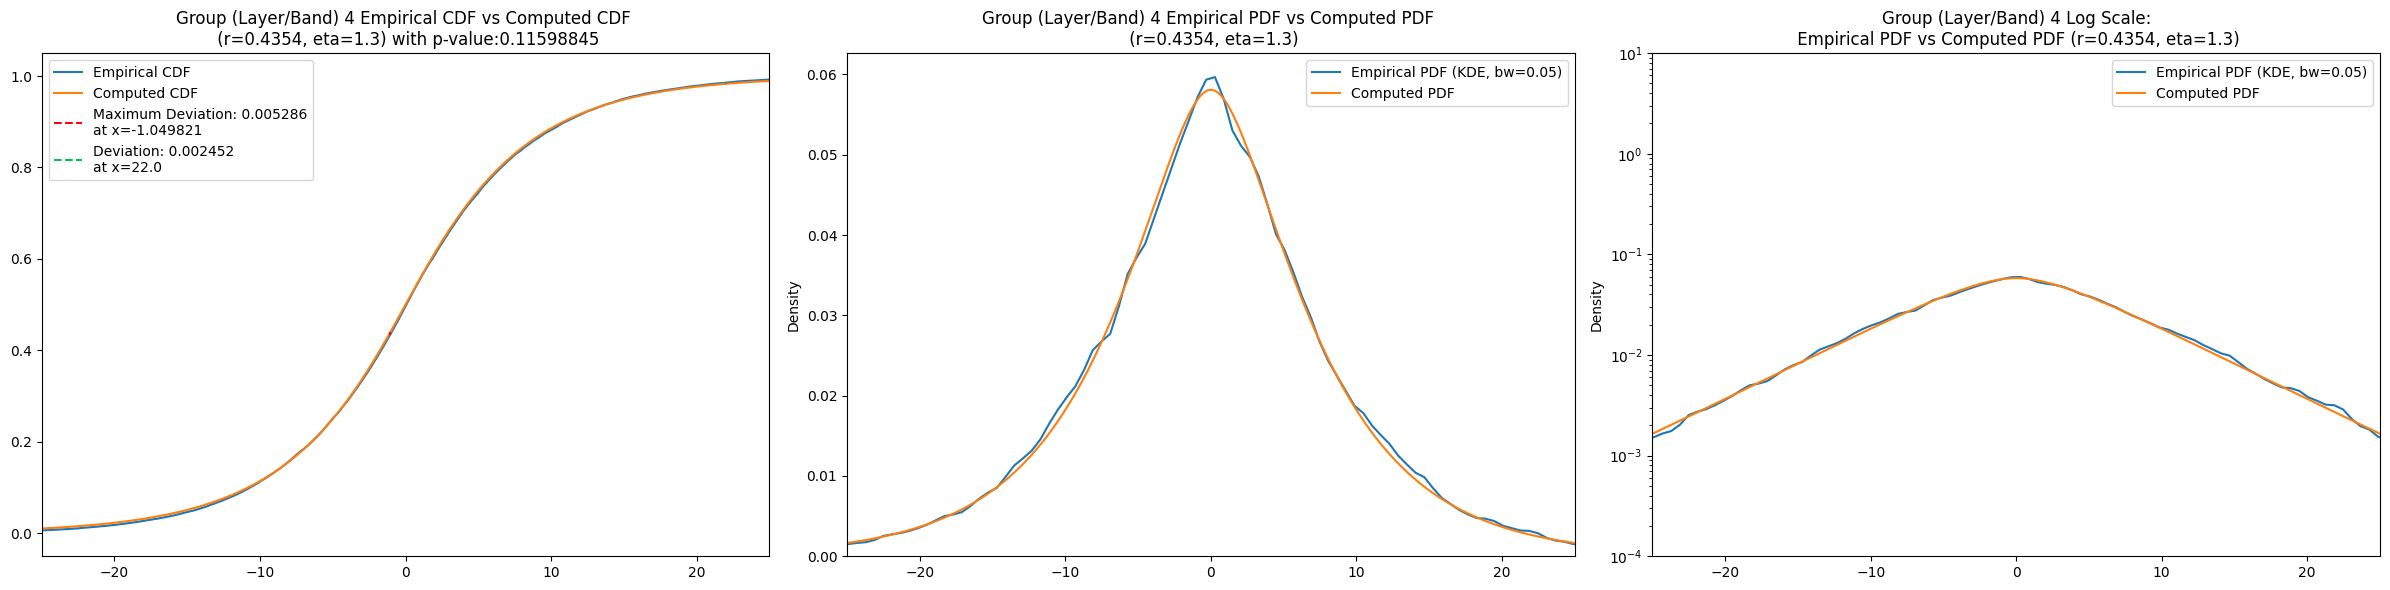

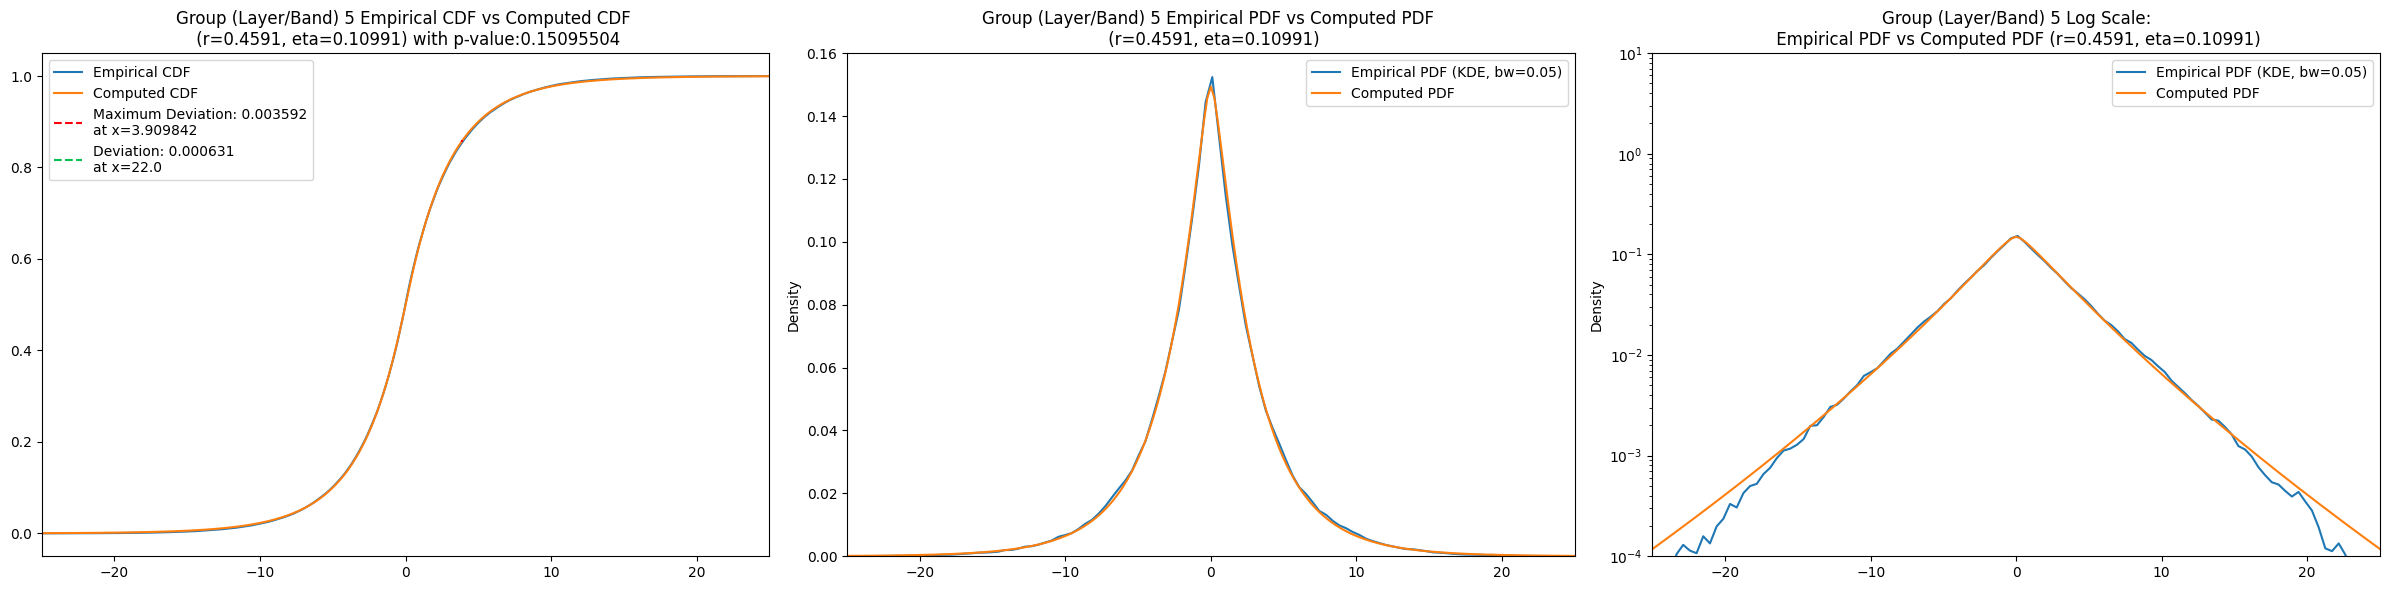

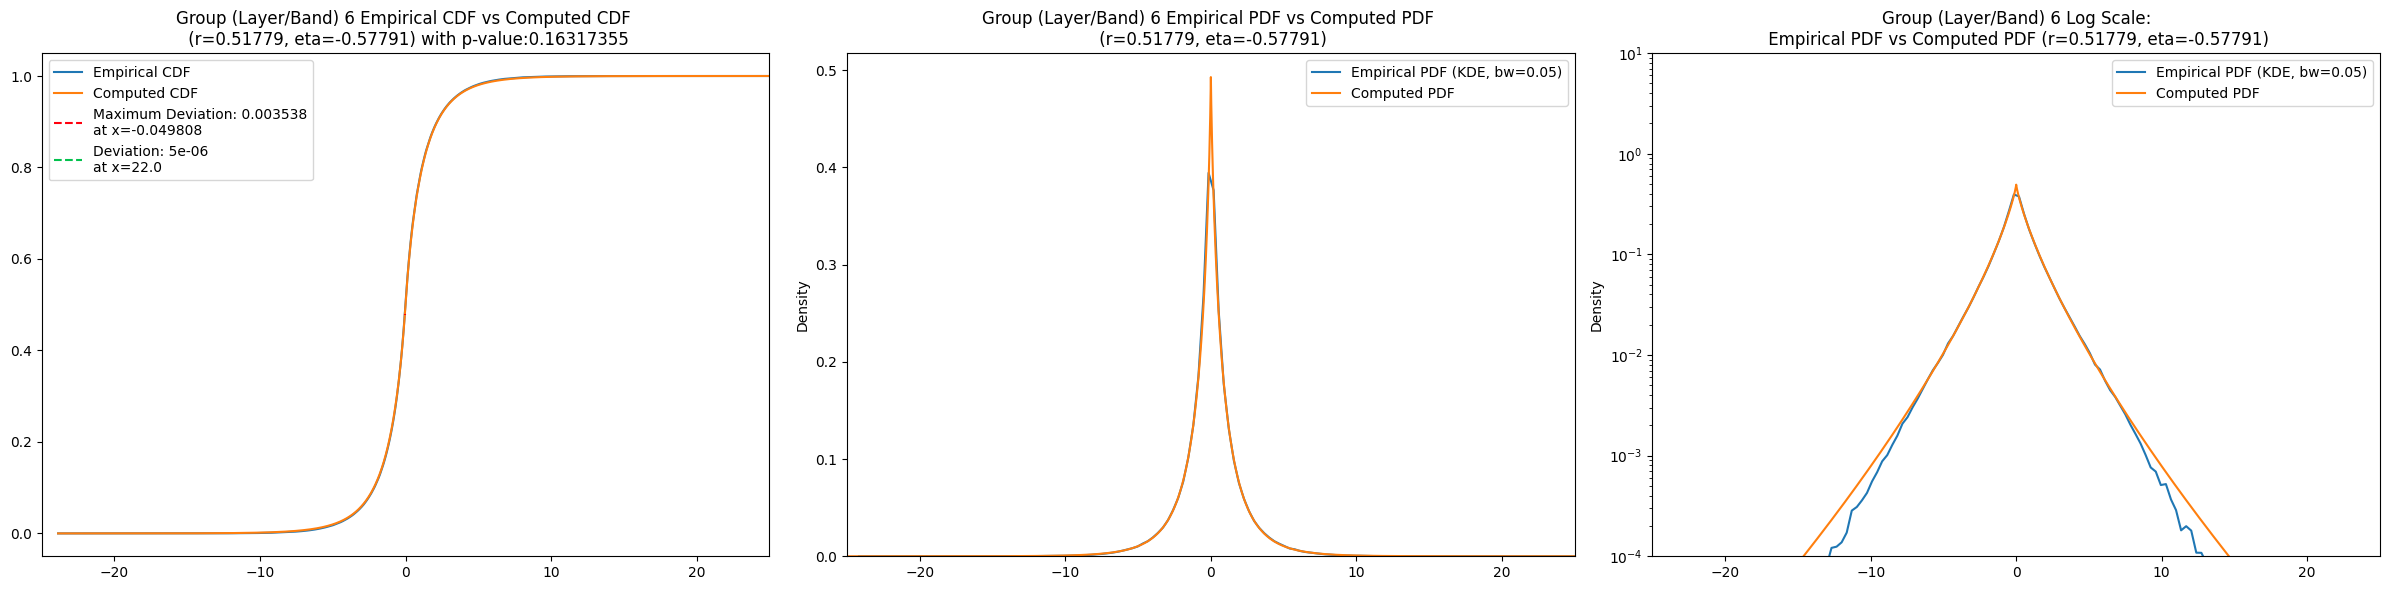

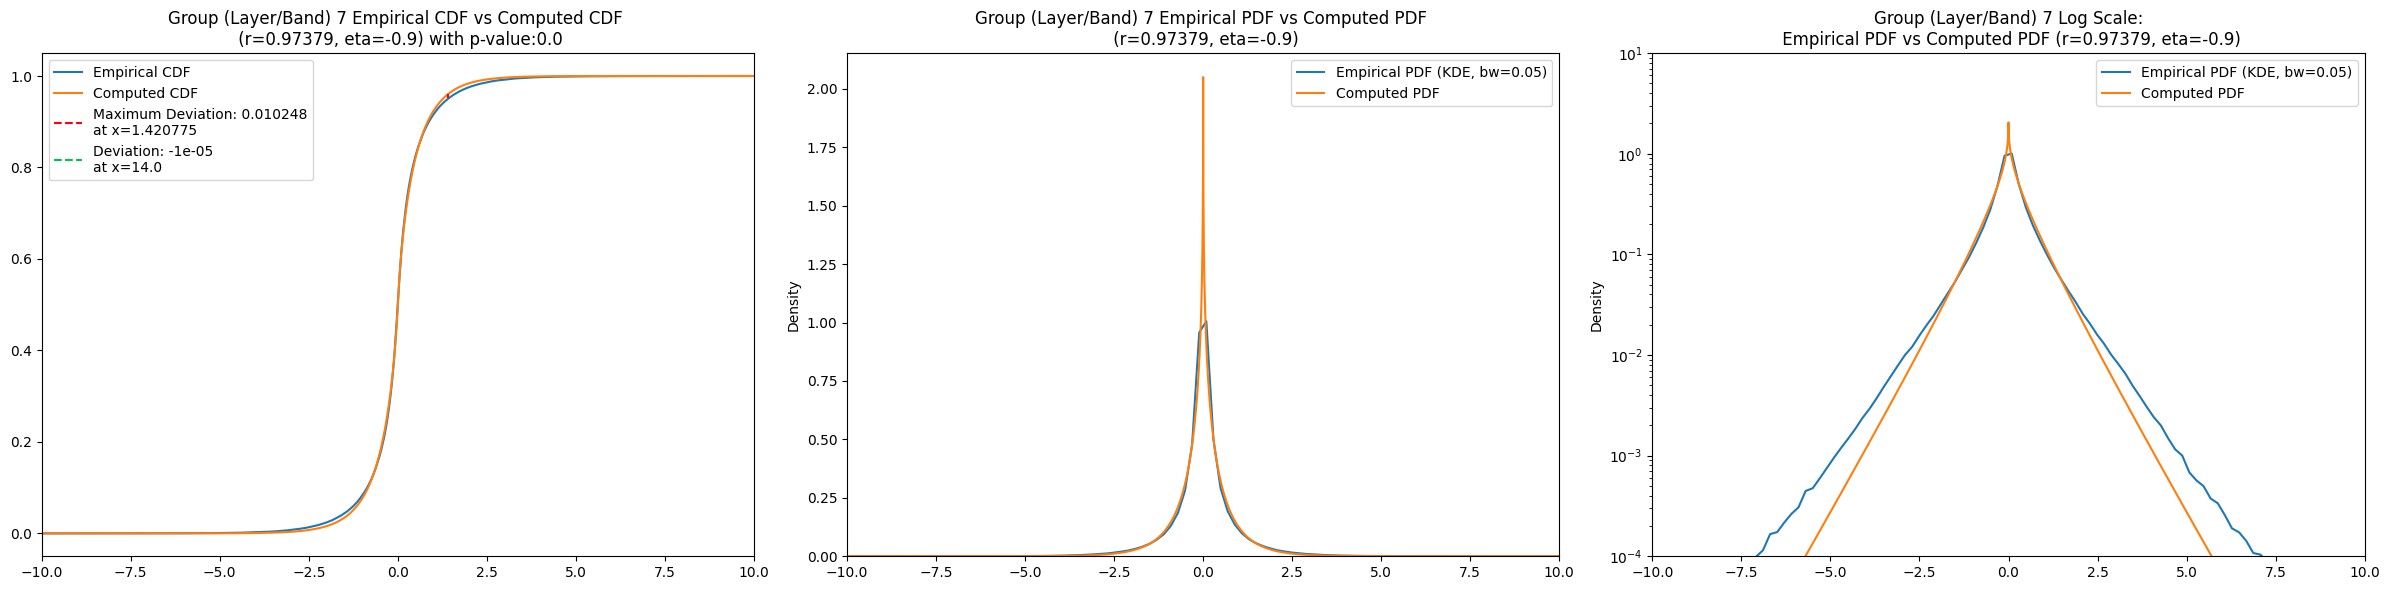

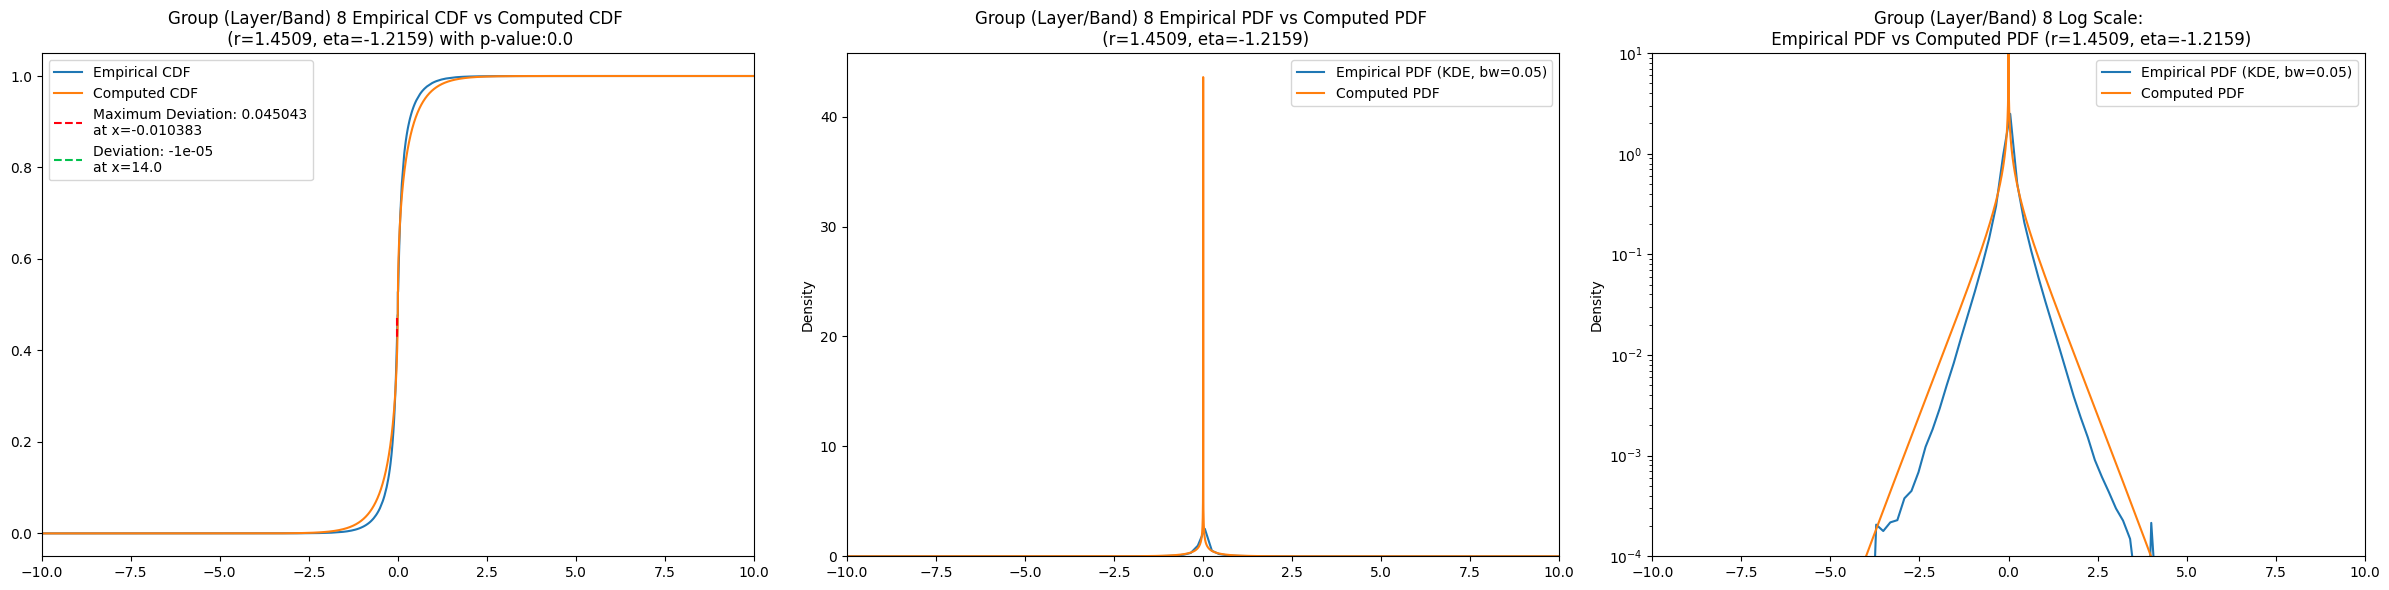

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-500, 500),
                    provided_loc=200)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0,0.42,5.7,0.018069,...,27.782300,0.019503,1.755550e-01,25.439100,0.036392,4.282210e-04,20.752800,0.036305,4.458110e-04,2.798600e-01
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0,0.51,7.3,0.004615,...,16.031400,0.010128,1.460870e-01,14.012900,0.022665,4.151010e-06,11.277100,0.026410,3.854630e-08,9.765300e-01
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0,0.44,1.4,0.006270,...,8.001070,0.020474,5.852830e-19,7.104980,0.014498,1.017140e-09,5.719650,0.018489,1.538450e-15,1.159900e-01
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0,0.47,0.2,0.005236,...,3.590200,0.030178,1.856120e-161,3.138870,0.002344,2.129390e-01,2.574090,0.010570,3.529230e-20,1.043800e-02
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0,0.51,-0.6,0.004349,...,1.426190,0.042375,0.000000e+00,1.246800,0.014481,1.041130e-148,1.010540,0.017941,4.909420e-228,2.818200e-09
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0,0.97,-0.9,0.010413,...,0.539656,0.052929,0.000000e+00,0.472760,0.025282,0.000000e+00,0.378321,0.026440,0.000000e+00,1.760700e-297
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0,1.44,-1.2,0.051520,...,0.196027,0.056358,0.000000e+00,0.172569,0.029152,0.000000e+00,0.137349,0.028140,0.000000e+00,0.000000e+00


In [ ]:
# def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
#     if metric_name == 'kstest_ratio':
#         metric = compute_ksratio
#     elif metric_name == 'kstest_stat':
#         metric = compute_ksstat_tail

#     for tail_cutoff in tail_cutoffs:
#         metrics = []
#         for layer in layers:
#             if distro == 'gengamma':
#                 cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
#             elif distro == 'gaussian':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
#             elif distro == 'laplace':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
#             elif distro == 't':
#                 cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
#             metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
#         master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
# for group in GROUPS:
#     add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
#     add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

# master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

# master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
# master_df

/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:577: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:577: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:577: RuntimeWarning: divide by zero encountered in divide
  tail_ratios =

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,kstest_ratio_gengamma_tail0,kstest_ratio_gengamma_tail10,kstest_ratio_gaussian_tail0,kstest_ratio_gaussian_tail10,kstest_ratio_laplace_tail0,kstest_ratio_laplace_tail10,kstest_ratio_t_tail0,kstest_ratio_t_tail10,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0,0.42,5.7,0.018069,...,"(0.1239, 1.0126)","(0.1239, 1.0126)","(0.9368, 1.9545)","(0.9368, 1.9545)","(0.95089, 7.3557)","(0.95089, 7.3557)","(0.015521, 1.04)","(0.015521, 1.04)",0.018069,0.018069
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0,0.51,7.3,0.004615,...,"(0.25381, 1.016)","(0.25381, 1.016)","(0.96671, 76.943)","(0.96671, 76.943)","(0.96151, 2839.9)","(0.96151, 2839.9)","(0.0074015, 1.1147)","(0.0074015, 1.1147)",0.004615,0.003824
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0,0.44,1.4,0.006270,...,"(0.098794, 1.0029)","(0.098794, 1.0029)","(0.93633, 391120.0)","(0.97872, 391120.0)","(0.95756, 119260000.0)","(0.95756, 119260000.0)","(0.003275, 1.0744)","(0.003275, 1.0176)",0.005812,0.005487
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0,0.47,0.2,0.005236,...,"(0.28817, 3.9814)","(0.28817, 3.9814)","(0.90723, 1.8721999999999998e+35)","(0.98075, 1.8721999999999998e+35)","(0.95007, 1.8763e+47)","(0.97884, 1.8763e+47)","(0.006972, 1.0662)","(0.006972, 1.0104)",0.003322,0.001374
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0,0.51,-0.6,0.004349,...,"(0.37732, 1.0407)","(0.37732, 1.0407)","(0.87959, 3.0205e+57)","(0.99905, 3.0205e+57)","(0.9364, 2.0407000000000003e+76)","(0.99905, 2.0407000000000003e+76)","(0.011194, 1.2183)","(0.011194, 1.0041)",0.002538,0.000984
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0,0.97,-0.9,0.010413,...,"(0.95921, 15312000.0)","(0.99998, 15312000.0)","(0.8501, 6.528000000000002e+269)","(0.99998, 6.528000000000002e+269)","(0.90641, inf)","(0.99998, inf)","(0.037871, 1.5063)","(0.037871, 1.0006)",0.008446,0.000030
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0,1.44,-1.2,0.051520,...,"(0.32023, 962020000000000.0)","(1.0, 962020000000000.0)","(0.83653, inf)","(1.0, inf)","(0.89532, inf)","(1.0, inf)","(0.061503, 1.7144)","(0.37126, 1.0)",0.002504,0.000010


## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\CSVs\\master_df.csv'

In [ ]:
master_df#.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,total_samples,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,kstest_stat_best,kstest_stat_iter1,kstest_stat_iter2,kstest_stat_iter3,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,,,,,
2,3180.0,0.018069,0.024030,0.060346,0.017520,0.017542,0.017520,NaN,0.019503,0.036392,0.036305,0.018069,0.018069
3,12720.0,0.004615,0.012029,0.037012,0.004221,0.004263,0.004221,NaN,0.010128,0.022665,0.026410,0.004615,0.003824
4,50880.0,0.006270,0.006018,0.023319,0.005286,0.005315,0.005286,NaN,0.020474,0.014498,0.018489,0.005812,0.005487
5,203520.0,0.005236,0.003010,0.005653,0.003592,0.003866,0.003596,0.003592,0.030178,0.002344,0.010570,0.003322,0.001374
6,814080.0,0.004349,0.001505,0.020507,0.003538,0.003590,0.003542,0.003538,0.042375,0.014481,0.017941,0.002538,0.000984
7,3256320.0,0.010413,0.000753,0.082284,0.010248,0.010258,0.010249,0.010248,0.052929,0.025282,0.026440,0.008446,0.000030
8,13025280.0,0.051520,0.000376,0.227351,0.045043,0.046824,0.045086,0.045043,0.056358,0.029152,0.028140,0.002504,0.000010
